# Week of 2025.04.28 

**Goals for the week:**
- [ ] Atmosphere integration 
    - [x] It appears from my [work the previous week](https://paxtonsc.github.io/files/geophysics/volcano_project/2025.04.14.experiments.html) that so long as we run the atmosphere simulation with a solution order of `0` the number of timesteps does not need to be increased. Experiment this week to see if that order is sufficient. **zeroth order appears insufficient.**
    - [x] Increase the mesh size so that we can compare the high station (2000m horizontal to the conduit) to the simulated data. 
    - [x] Update the mesh conduit radius to match the 5m in the eruption simulation.
    - [ ] Reach out to Fred to ask a couple questions about how the mesh works.
    - [ ] Generate synthetic infrasound data at the station locations and compare to recorded infrasound data. Mario ball park  expects 800 Pa.
    - [ ] Try to increase the order of the infrasound animation. This may require messing with the mesh. 
    - [ ] Compare numerical results to rough analytical calculation based on this [paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021JB021940). Use the rough calculation to also get the sense whether our current model is on the right order.  
- [x] Debugging the low density eruption simulation
    - [x] Why is the density/speed of sound so low? Mario was setting the mass fraction of water as the porosity (incorrect).
    - [x] Look into how to have the volume fraction of gas taken in as an initial condition? I decided it makes more sense to set the parameters correctly such that the gas volume fraction is what we want rather than directly setting the gas volume fraction. 
- [ ] Simple model for simulating parameters 
    - [ ] Review jump conditions + self similar rarefaction 
    - [ ] How can we create a simple model of the volcano eruption that accurately reflects the fragmentation front? 
- [ ] Get Mario's code for mapping pressure -> seismic behavior 

**Questions that arise:**
- [ ] How should I go about updating the mesh to make the simulation run at a higher order faster. Maybe a Fred question?

## 1.0 Generate synthetic infrasound data at the measuring stations

**Notes from Mario on how to handle the real infrasound data:**
- Band pass the infrasound data from 1 -> 20 Hz (use obspy)
- Mario has the factor of conversation (Mario to email it to Paxton) Mario will forward email with conversation factors. 
- We expect to see order 800 Pa
- Probably need the simulation to be 15 seconds. 

### 1.1 Review the updated eruption model

First, let's review the volcano eruption. Mario suggested some changes to the configuration file to reduce the low density in the plug we were seeing.

In [2]:
ITERS=150
from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func
from helper_code.animate import animate_conduit_pressure

In [ ]:
solver_func = get_local_solver_from_index_func("eruption_model", "tungurahua_rad_5_v23_conduit")
ani = animate_conduit_pressure(solver_func, iterations=ITERS, viscosity_index=1, wall_friction_index=5, max_velocity=30, max_slip=60, max_tau=0.1, max_pressure=50, max_speed_of_sound=2000, max_water=20, max_density=5e3, max_fragmentation=5000, max_crystal=10)

HTML(ani.to_html5_video())

### 1.2 Animate pressure over time with quail atmospheric model

How exactly does the atmosphere axisymmetric simulation work? Fred makes some notes in his [thesis](https://drive.google.com/drive/folders/1xwnqopoice-zy-8HfxhxLIeNJFAgZX5L). 

In [12]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import processing.mdtools as mdtools

# Assume solver2D_from is available as in the original code
solver2D_from = get_local_solver_from_index_func("eruption_model", "test_infrasound_v22_atm1")

# Set up figure
fig = plt.figure(figsize=(8, 6))

# Define pressure range for colormap
clims = (0.9e5, 1.01325e5)

# Initialize with first frame (index 0)
x, p = mdtools.downsample(solver2D_from(0), plot_qty="Pressure")
p0 = p.copy()  # Store initial pressure for reference
mdtools.plot_mean(x, p, clims)

# Set up colorbar
sm = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap()
)
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa)")

# Animation update function
def update(frame):
    plt.cla()  # Clear current axis
    # Fetch data for current frame
    x, p = mdtools.downsample(solver2D_from(frame), plot_qty="Pressure")
    # Update plot
    mdtools.plot_mean(x, p, clims)
    plt.title(f"Pressure Field at Sec {round(0.1 * frame)}")
    return plt.gca(),

# Create animation
# Assume 100 frames for simulation; adjust based on solver data
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, ITERS, 1),  # Adjust range based on available solver indices
    interval=100,  # Time between frames in milliseconds
    blit=False
)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

### 1.3 Relative pressure

We subtract out the initial pressure in order to only look at relative pressure, which is the quantity we are interested in.  

In [162]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import processing.mdtools as mdtools

# Assume solver2D_from is available as in the original code
solver2D_from = get_local_solver_from_index_func("eruption_model", "test_infrasound_v22_atm1")

# Set up figure
fig = plt.figure(figsize=(8, 6))

# Define pressure range for colormap
clims = (-1e2, 5e2)

# Initialize with first frame (index 1)
x, p = mdtools.downsample(solver2D_from(0), plot_qty="Pressure")
p0 = p.copy()  # Store initial pressure for reference
mdtools.plot_mean(x, p-p0, clims)

# Set up colorbar
sm = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=0, vmax=1e3),
    cmap=plt.get_cmap()
)
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa)")

# Animation update function
def update(frame):
    plt.cla()  # Clear current axis
    # Fetch data for current frame
    x, p = mdtools.downsample(solver2D_from(frame), plot_qty="Pressure")
    # Update plot
    mdtools.plot_mean(x, p-p0, clims)
    plt.title(f"Pressure Field at Sec {0.1 * frame}")
    return plt.gca(),

# Create animation
# Assume 100 frames for simulation; adjust based on solver data
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, 80, 1),  # Adjust range based on available solver indices
    interval=100,  # Time between frames in milliseconds
    blit=False
)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

Wow! That is pretty noisy. It is a little tricky to tell what is proper falloff versus numerical errors. 

#### Next, let's plot the relative pressure at the high station. 

Where is the high station? According to [this paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2017GL076419) it is 2000m horizontally from the outlet! I had to go back an expand the size of the mesh, but now we have data for the necessary domain. 

Next, let's create a plot of pressure versus time at a point roughly where the high station is. 

In [163]:
import matplotlib.tri as tri

# Assume solver2D_from is available as in the original code
solver2D_from = get_local_solver_from_index_func("eruption_model", "test_infrasound_v22_atm1")


triangulation = tri.Triangulation(solver2D_from(0).mesh.node_coords[...,0],
                  solver2D_from(0).mesh.node_coords[...,1], 
                  triangles=solver2D_from(0).mesh.elem_to_node_IDs)
                  
trifinder = triangulation.get_trifinder()

def find_elem_ID(x, y):
  ''' Returns element ID corresponding to given x and y. '''
  return trifinder(x, y)

def get_p_series(x_target, y_target):

  # Find the element ID
  elem_ID = find_elem_ID(x_target, y_target)

  print(f"Element ID for point ({x_target}, {y_target}): {elem_ID}")

  p_relative_arr = []
  p0 = None

  for i in range(0, ITERS):
      # Get the solver state at the current time step
      solver2D = solver2D_from(i)

      solver2D_0 = solver2D_from(0)

      U = solver2D.state_coeffs
      U_target = U[elem_ID:elem_ID+1]

      # Compute pressure using the state vector
      p_target = solver2D_0.physics.compute_variable("Pressure", U_target)

      if i == 0:
          p0 = np.average(p_target)

      p_relative_arr.append(np.average(p_target) - p0)
  
  return p_relative_arr
  

In [164]:
p_relative_arr_500 = get_p_series(500, -200)
p_relative_arr_1000 = get_p_series(1000, -400)
p_relative_arr_1500 = get_p_series(1500, -600)
p_relative_arr_2000 = get_p_series(2000, -800)


Element ID for point (500, -200): 4369
Element ID for point (1000, -400): 633
Element ID for point (1500, -600): 1947
Element ID for point (2000, -800): 4373


Text(0.5, 0.98, 'Pressure Time Series at Different Distances from the outlet')

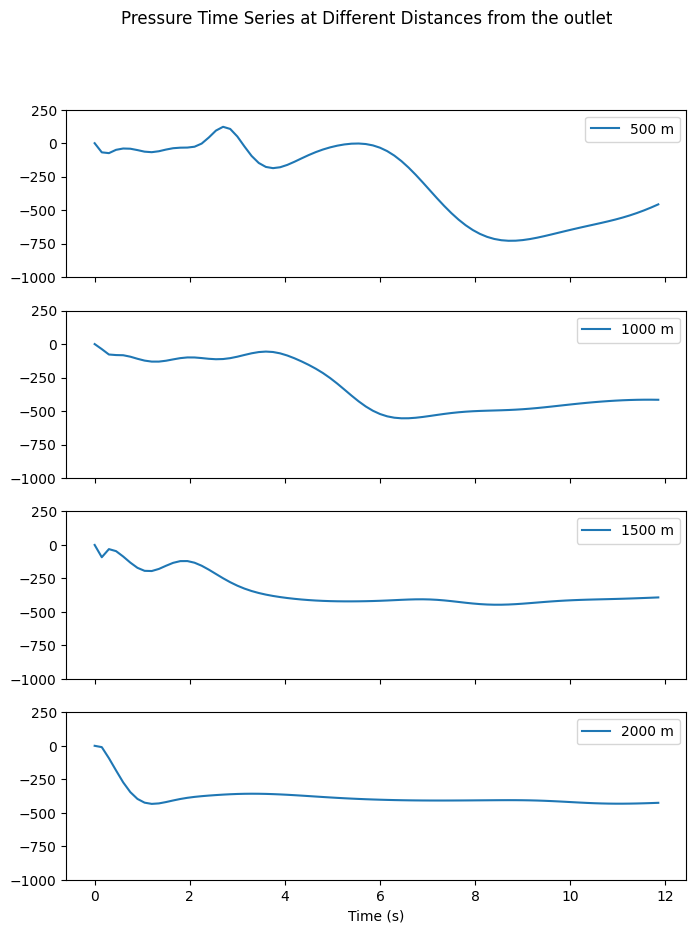

In [165]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 10), sharex=True)

axes[0].plot(np.arange(0, ITERS*(15/100), 15/100), p_relative_arr_500, label="500 m")
axes[1].plot(np.arange(0, ITERS*(15/100), 15/100), p_relative_arr_1000, label="1000 m")
axes[2].plot(np.arange(0, ITERS*(15/100), 15/100), p_relative_arr_1500, label="1500 m")
axes[3].plot(np.arange(0, ITERS*(15/100), 15/100), p_relative_arr_2000, label="2000 m")

for ax in axes:
    ax.set_ylim(-1e3, 250)
    ax.legend()
    
plt.xlabel("Time (s)")
fig.suptitle("Pressure Time Series at Different Distances from the outlet")

It is odd that in the above chart the pressure drops about 400 Pascals. I am guessing that is just a function of diffusive numerical error. 

## 2.0 Simple analytical model to predict atmospheric pressure

The downside of the atmospheric coupling in quail is that the model is complicated and I don't fully understand it. As a small project, I am going to create a simple numerical solution for atmosphere based on treating the volcano as a monopole acoustic source where the pressure wave is a function purely of the ejected volume, which we consider to be incompressible. 

Eric shared [notes](https://drive.google.com/file/d/1khrmHWfoOqrcBjE533TtZirvnp9IIAc3/view?usp=sharing) on 3D acoustics, from which I will use the relation 

$$
p(r,t) = \frac{\rho \dot{Q}(t-r/c)}{4 \pi r * (2/3)}
$$

To create a simple model for pressure as a function of time and radius. The $2/3$ factor comes from the fact that the volcano occupies 1/3 of the angular space around the monopole source. Note that $Q(t)$ is volume outflow, which in our situation can be expressed as 

$$ Q(t) = s \pi  r^2 $$

and the derivative can be expressed 

$$ \dot{Q}(t) = \dot{s} \pi r^2$$

Where $\dot{s}$ is the derivative of slip, or simply velocity. 

We also need to know both the speed of sound $c$ and $\rho$ both of which are functions of altitutde. From Wikipedia, 

$$ p = p_0 *\exp(- \frac{g * h *M}{T_O * R_0})$$


- $T_0 = 288.15 [K]$ (sea level temp)
- $ M = 0.02896968 [kg/mol]$ (Molar mass of dry air)
- $R_0 = 8.314462618 [J/(mol·K)]$ (gas constant)
- $p_0 = 101,325 [Pa]$ (pressure at sea level).
- $c = 320 [m/s]$ (speed of sound, we will define as a constant for now)

In [4]:
T_0 = 288.15 # [K]
M = 0.02896968 # [kg/mol]
R_0 = 8.314462618 #[J/(mol·K)]
p_0 = 101325 # [Pa]
g = 9.81 # [m/s^2]

L = 0.0065    # Temperature lapse rate (K/m)
gamma = 1.4   # Specific heat ratio for air

def pressure(h):
    return p_0 * np.exp(-M * g * h / (R_0 * T_0)) # [Pa]

def density(h):
    T = T_0 - L * h
    P = pressure(h)

    return P / (R_0 * T)

def sound_speed(h):
    # Setting speed of sound to a constant value for simplicity
    return 320 #[m/s]

def point_in_volcano(x, y):
    # Define the volcano shape
    # This is a placeholder function; replace with actual volcano shape logic
    if y < -1/2 * x and y < 1/2 * x:
        return True
    else:
        return False


### 2.1 Set initial conditions 

In [5]:
from scipy.interpolate import interp1d

solver_func = get_local_solver_from_index_func("eruption_model", "tungurahua_rad_5_v23_conduit")

u_vec = []
t_vec = []
R = 50 # m

for i in range(0, 150, 1):
    solver = solver_func(i)
    momentum = solver.state_coeffs[:,:,solver.physics.get_momentum_slice()]
    rho = np.sum(solver.state_coeffs[:, :, solver.physics.get_mass_slice()],axis=2,keepdims=True)

    # Define velocity as momentum divided by density. "velocity" when computed as an additional state variable appears to be an absolute value. 
    u = momentum.ravel() / rho.ravel()

    # Take only the exit velocity
    u_vec.append(np.maximum(u[-1], 0))
    t_vec.append(solver.time)


Q_dot = np.pi * R**2 * np.array(u_vec) # m^3/s

def Q_dot_func(t):
    if t < t_vec[0] or t > t_vec[-1]:
        return 0
    
    # Create interpolator for each grid point
    interpolator = interp1d(t_vec, Q_dot, kind='linear', fill_value="extrapolate")
    
    # Evaluate at time t
    interpolated_Q = interpolator(t)
    
    # Linear interpolation
    return interpolated_Q


def relative_pressure(t, x, y):
    r = np.sqrt(x**2 + y**2)
    rho = density(y)

    # 2/3 comes from the fact that 1/3 of the outward area is solid volcano
    return rho * Q_dot_func(t - r / sound_speed(y)) / ((2/3) * np.pi * 4 * r)

### 2.2 Animate pressure wave based on monopole source 


In [6]:
from matplotlib.animation import FuncAnimation

N = 250
pressure_array = np.zeros((N, N))
x_low, x_upper = -500, 3000
y_low, y_upper = -1000, 2500

# Set up the figure and axis
fig, ax = plt.subplots()
im = ax.imshow(pressure_array, extent=[x_low, x_upper, y_low, y_upper], 
               aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=150)
plt.colorbar(im, label='Pressure (Pa)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Pressure Distribution Over Time')

# Initialization function for animation
def init():
    im.set_array(np.zeros((N, N)))
    return [im]

# Animation update function
def update(t):
    for i in range(N):
        for j in range(N):
            x = x_low + (x_upper - x_low) * i / N
            y = y_low + (y_upper - y_low) * j / N

            if point_in_volcano(x, y):
                pressure_array[j][i] = 0  # Set pressure to 0 inside volcano
            else:
                pressure_array[j][i] = relative_pressure(t, x, y)

    im.set_array(pressure_array)
    ax.set_title(f'Pressure Distribution at t={t:.2f} s')
    return [im]

# Create animation
ani = FuncAnimation(fig, update, init_func=init, frames=np.asarray(t_vec[0:100]), 
                    interval=50, blit=True)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up


Next, let's inspect what the pressure graph at the point (-2000, -1000) would look like over the time scale that we are simulating for (15 seconds). We should at least be able to do an order of magnitude comparison to the REAL infrasound data below. 

In [7]:
pressure_at_500 = []
pressure_at_1000 = []
pressure_at_1500 = []
pressure_at_2000 = []

for t in t_vec:
    pressure_at_500.append(relative_pressure(t, 500, -250))
    pressure_at_1000.append(relative_pressure(t, 1000, -500))
    pressure_at_1500.append(relative_pressure(t, 1500, -750))
    pressure_at_2000.append(relative_pressure(t, 2000, -1000))

Text(0.5, 0.98, 'Pressure vs time at different distances from the outlet')

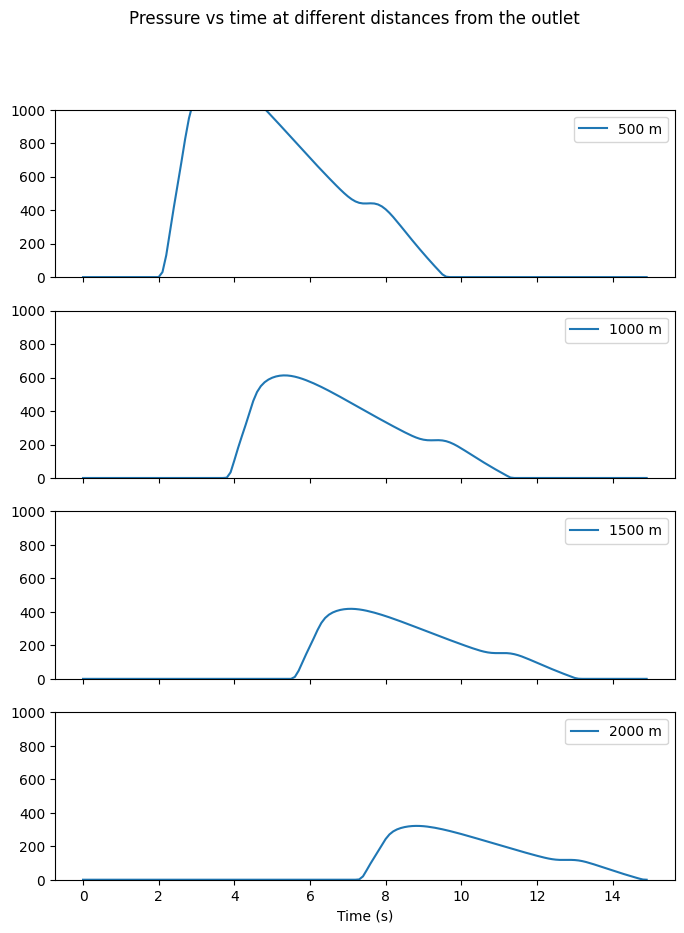

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 10), sharex=True)

axes[0].plot(t_vec, pressure_at_500, label="500 m")
axes[1].plot(t_vec, pressure_at_1000, label="1000 m")
axes[2].plot(t_vec, pressure_at_1500, label="1500 m")
axes[3].plot(t_vec, pressure_at_2000, label="2000 m")

for ax in axes:
    ax.set_ylim(0, 1000)
    ax.legend()

axes[-1].set_xlabel("Time (s)")

fig.suptitle("Pressure vs time at different distances from the outlet")


## 3.0 Observed infrasound data

The infrasound data can be found [here](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2017GL076419). Well actually, I was unable to find a good way to download it from that link, but Mario shared this [google folder](https://drive.google.com/file/d/1uE-DbUshRbbkA-Hd7m-4wGWKaa8iPmGi/view?usp=drive_link) with me.

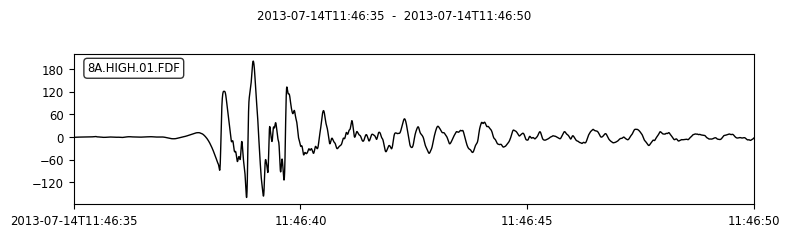

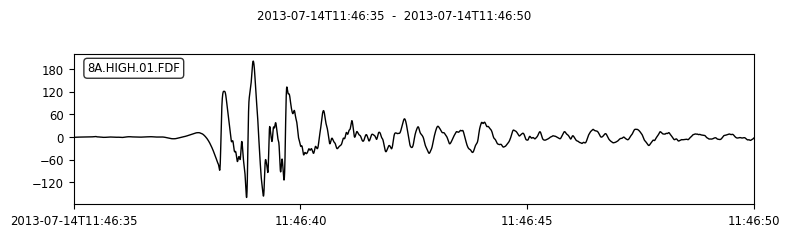

In [39]:
import matplotlib.pyplot as plt
import numpy as np

import obspy
from obspy import read, Stream, UTCDateTime
from obspy.io.mseed.util import get_record_information

file_path = "/Users/paxton/git/volcano_sims/infrasound_data/8A.HIGH.2013-07-14.mseed"

st = read(file_path)

tr0 = st[0]
tr0_filtered = tr0.copy()

freqmin = 1
freqmax = 20
tr0_filtered.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)

tr0_filtered.data = tr0_filtered.data * 1.589e-6 /  23e-6

t1 = UTCDateTime("2013-07-14T11:46:35")
t2 = UTCDateTime("2013-07-14T11:46:50")

tr0_filtered.trim(t1, t2)

tr0_filtered.plot()